# MNIST from scratch with numpy

In [14]:
# load changed modules automatically
%reload_ext autoreload
%autoreload 2

In [15]:
# load numpy
import numpy as np

# load dataloaders and required layers
from mnist import dataloader
from mnist.layers import Softmax, Linear, Dropout, ReLU
from mnist.losses import CrossEntropy

# load pyplot for displaying images
from matplotlib import pyplot as plt

# show images inline on notebook
%matplotlib inline

# debugging
import pdb

## Load training data

In [16]:
dl = dataloader.DataLoader()
((x_train, y_train), (x_valid, y_valid), (x_test, (y_test))) = dl.load_data()

In [17]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((50000, 784), (50000,), (10000, 784), (10000,))

## Normalize data

In [18]:
(x_train, y_train), (x_valid, y_valid) = dl.normalize(((x_train, y_train), (x_valid, y_valid)))

## Exploring the data

In [24]:
def show(img):
    plt.imshow(img, cmap="gray")

In [ ]:
valid_images = np.reshape(x_valid, (-1,28,28))

In [ ]:
show(valid_images[0])

## Start building the model

In [19]:
def shuffle(arr1, arr2):
    random_idxs = np.arange(len(arr1))
    np.random.shuffle(random_idxs)
    return arr1[random_idxs], arr2[random_idxs]

In [20]:
# always reproduce the same weights
#np.random.seed(1)

class Net(object):
        
    def __init__(self, n_input=28*28, n_hidden1=256, n_hidden2=256, n_output=10):
        self.train = True
        
        self.input_dropout = Dropout(0.01)
        self.input_layer = Linear(n_input, n_hidden1)
        
        self.relu1 = ReLU()
        self.dropout1 = Dropout(0.5)
        self.hidden1 = Linear(n_hidden1, n_hidden2)

        self.relu2 = ReLU()
        self.dropout2 = Dropout(0.01)
        self.hidden2 = Linear(n_hidden2, n_output)

        self.softmax = Softmax()
        self.loss_func = CrossEntropy()
    
    def forward(self, x):
        if self.train:
            x = self.input_dropout.forward(x)

        x = self.input_layer.forward(x)

        if self.train:
            x = self.dropout1.forward(x)
    
        x = self.relu1.forward(x)
        x = self.hidden1.forward(x)

        if self.train:
            x = self.dropout2.forward(x)

        x = self.relu2.forward(x)
        x = self.hidden2.forward(x)
        
        x = self.softmax.forward(x)
        return x
    
    def backward(self, targets):
        grads = {}
        
        grad_loss = net.softmax.backward(targets)

        grad_hidden2_inputs, grad_hidden2_weights, grad_hidden2_bias = net.hidden2.backward(grad_loss)
        grads['w3'] = grad_hidden2_weights
        grads['b3'] = grad_hidden2_bias
        
        grad_relu = net.relu2.backward(grad_hidden2_inputs)

        grad_hidden1_inputs, grad_hidden1_weights, grad_hidden1_bias = net.hidden1.backward(grad_relu)
        grads['w2'] = grad_hidden1_weights
        grads['b2'] = grad_hidden1_bias

        grad_relu = net.relu1.backward(grad_hidden1_inputs)

        grad_inputs, grad_input_weights, grad_input_bias = net.input_layer.backward(grad_relu)
        grads['w1'] = grad_input_weights
        grads['b1'] = grad_input_bias
        
        return grads
    
    def loss(self, y_pred, y):
        return self.loss_func.loss(y_pred, y)

net = Net(n_input=28*28, n_hidden1=256, n_hidden2=64, n_output=10)

In [21]:
debug = False

if debug:
    n_epochs = 1
    batch_size = 3
else:
    n_epochs = 20
    batch_size = 256
    
learning_rate = 1e-1

for epoch in range(n_epochs):
    
    for i in range(0, len(x_train), batch_size):

        inputs = x_train[i:i+batch_size]
        targets = y_train[i:i+batch_size]
        
        inputs, targets = shuffle(inputs, targets)

        if debug:
            print("inputs.shape", inputs.shape)
            print("targets.shape", targets.shape)

        # forward propagation
        y_pred = net.forward(inputs)
        predictions = y_pred.copy()

        if debug:
            print("y_pred.shape:", y_pred.shape)
            print("predictions.shape", predictions.shape)
            
        # calculate cross-entropy loss
        loss = net.loss(predictions, targets)
        
        if debug:
            print(epoch, loss)
        
        # backpropagation
        grads = net.backward(targets)
        
        if debug:
            print("w1.shape", grads['w1'].shape)
            print("b1.shape", grads['b1'].shape)
            print("w2.shape", grads['w2'].shape)
            print("b2.shape", grads['b2'].shape)
            
        net.input_layer.weights -= learning_rate * grads['w1']
        net.input_layer.bias -= learning_rate * grads['b1']
        
        net.hidden1.weights -= learning_rate * grads['w2']
        net.hidden1.bias -= learning_rate * grads['b2']

        net.hidden2.weights -= learning_rate * grads['w3']
        net.hidden2.bias -= learning_rate * grads['b3']
        
        if debug:
            break
        
    # calculate validation loss for some random indices
#     net.train = False
#     random_idxs = np.random.randint(0, len(x_valid), batch_size)
#     y_valid_pred = net.forward(x_valid[random_idxs])
#     loss_valid = net.loss(y_valid_pred, y_valid[random_idxs])
#     net.train = True


    net.train = False
    y_valid_pred = net.forward(x_valid)
    loss_valid = net.loss(y_valid_pred, y_valid)
    net.train = True

    #calculate accuracy and validation accuracy
    accuracy = np.mean(y_pred.argmax(axis=1) == targets)
    valid_accuracy = np.mean(y_valid_pred.argmax(axis=1) == y_valid)
    
    print(epoch, loss, loss_valid, accuracy, valid_accuracy)


0 2.204526887092844 2.1849000822959828 0.225 0.2088
1 0.5475592948171671 0.5627306641494987 0.8375 0.8325
2 0.38459536850989623 0.35825926267685443 0.925 0.8945
3 0.2754236548876779 0.25389087217608863 0.9375 0.9242
4 0.24122200546327494 0.1966455054814806 0.9375 0.9421
5 0.18474746947487813 0.17014792473003695 0.9375 0.9497
6 0.13826313171550206 0.14281611675777536 0.9625 0.9571
7 0.1418354444946957 0.12859858193897034 0.95 0.9619
8 0.10089261807711436 0.1165010883791176 0.9875 0.9664
9 0.12190666866166229 0.11170201921836631 0.95 0.9671
10 0.0817662162028858 0.10258808439319816 0.9875 0.9698
11 0.07020409116760706 0.09640664337103134 0.9875 0.9717
12 0.05592583702554177 0.09566927165836384 0.9875 0.972
13 0.07851278216779871 0.0887908847641861 0.9625 0.9735
14 0.04234429972817784 0.08674091976798616 1.0 0.9741
15 0.05140836187188584 0.08415198910921887 0.9875 0.9755
16 0.044057615461404 0.08504818549454218 1.0 0.9746
17 0.07809515121492513 0.08113659770213541 0.975 0.9758
18 0.047339

## Check results

In [22]:
# get some random examples from validation data,
# compare predictions with actual values
valid_preds = net.forward(x_valid)
random_idxs = np.random.randint(0, len(x_valid), 10)
np.argmax(valid_preds, axis=1)[random_idxs], y_valid[random_idxs]

(array([5, 1, 5, 0, 2, 3, 3, 7, 8, 7]), array([8, 1, 5, 0, 7, 3, 3, 7, 8, 7]))

prediction: 5 correct: 5


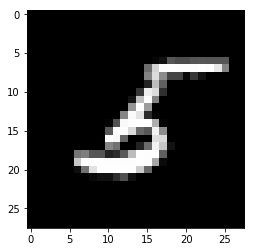

In [25]:
# display a random image from validation data with
# prediction and correct value
valid_images = np.reshape(x_valid, (-1,28,28))
valid_preds = net.forward(x_valid)
random_idx = np.random.randint(0, len(x_valid))
prediction = np.argmax(valid_preds, axis=1)[random_idx]
correct = y_valid[random_idx]
print("prediction:", prediction, "correct:", correct)
show(valid_images[random_idx])

In [26]:
# whole validation set accuracy
valid_preds = net.forward(x_valid)
valid_accuracy = np.mean(valid_preds.argmax(axis=1) == y_valid)
valid_accuracy

0.9665